# FAO Analysis - Analysis

This notebook is part of a general analysis on [Food and Agriculture Organization (FAO)](https://www.fao.org/home/en/) of the United Nations :  
1. 🚀 Exploration
2. 📁 Load, clean and merge
3. 📊 **Analysis visuals**

🎯 The main goal of this notebook is to load csv files, explore the data and run some analysis on that. 

## Imports and setup

In [1]:
import sys 
from pathlib import Path

project_folder = str(Path().resolve().parent)
if not project_folder in sys.path:
    sys.path.append(str(Path().resolve().parent))

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_utils import load_processed, load_one_csv
sns.set_theme(style="whitegrid")

## Load data

In [3]:
data = load_processed(strategy="keep")

✅ Loaded processed data from disk


In [4]:
data.keys()

dict_keys(['Production_Crops_Livestock', 'Land_Use', 'Emissions_Totals', 'Food_Balance'])

In [4]:
df_prod = data[list(data.keys())[0]]
df_land = data[list(data.keys())[1]]
df_emissions = data[list(data.keys())[2]]
df_balance = data[list(data.keys())[3]]

Country groups

In [5]:
df_country_groups = pd.read_csv(Path(project_folder) / "data/external/country_groups.csv")
country_groups = np.append(df_country_groups["Country Group"].unique(),"China, mainland")

Item groups

In [6]:
df_item_groups = pd.read_csv(Path(project_folder) / "data/external/item_groups.csv")
item_groups = df_item_groups["Item Group"].unique()

## Exploration and analysis

### Production Crops

**Quick analysis**

In [8]:
df_prod.sample(5)

,Area,Item,Element,Year,Unit,Value
2229964,Poland,Raw milk of sheep,Production,1966,t,6700.00
3139326,Africa,"Buffalo fat, unrendered",Producing Animals/Slaughtered,2001,An,1073468.00
1957415,Netherlands (Kingdom of the),"Pumpkins, squash and gourds",Production,1968,t,0.00
713678,Côte d'Ivoire,Raw hides and skins of sheep or lambs,Producing Animals/Slaughtered,1995,An,495000.00
154370,Austria,"Oilcrops, Oil Equivalent",Production,1992,t,98881.73


In [9]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116252 entries, 0 to 4116251
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Area     object 
 1   Item     object 
 2   Element  object 
 3   Year     int64  
 4   Unit     object 
 5   Value    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 188.4+ MB


In [10]:
df_prod.describe(include=np.number)

,Year,Value
count,4.116252e+06,3.962193e+06
mean,1.993280e+03,2.514710e+06
std,1.809356e+01,2.802884e+07
min,1.961000e+03,0.000000e+00
25%,1.978000e+03,1.211000e+03
50%,1.994000e+03,1.000000e+04
75%,2.009000e+03,1.058000e+05
max,2.023000e+03,3.134294e+09


In [11]:
df_prod.describe(exclude=np.number)

,Area,Item,Element,Unit
count,4116252,4116252,4116252,4116252
unique,245,302,8,10
top,World,"Hen eggs in shell, fresh",Production,t
freq,44334,68276,1645089,1627099


**Exploration**

In [12]:
df_prod["Area"].value_counts().nlargest(20)

World                                               44334
Asia                                                41186
Net Food Importing Developing Countries (NFIDCs)    40790
Americas                                            39087
Africa                                              38838
Low Income Food Deficit Countries (LIFDCs)          38446
Land Locked Developing Countries (LLDCs)            37195
Least Developed Countries (LDCs)                    35911
South America                                       35793
Eastern Asia                                        35514
Europe                                              35206
European Union (27)                                 34416
China                                               33956
Western Asia                                        33826
Southern Europe                                     33551
China, mainland                                     33327
Southern Asia                                       33135
Eastern Africa

In [13]:
df_prod["Item"].value_counts().nlargest(30)

Hen eggs in shell, fresh                           68276
Meat of chickens, fresh or chilled                 41500
Roots and Tubers, Total                            41330
Meat, Poultry                                      41303
Vegetables Primary                                 41252
Fruit Primary                                      41038
Beef and Buffalo Meat, primary                     40955
Meat of cattle with the bone, fresh or chilled     40931
Eggs Primary                                       40908
Other vegetables, fresh n.e.c.                     40686
Sheep and Goat Meat                                40065
Oilcrops, Oil Equivalent                           39140
Oilcrops, Cake Equivalent                          38743
Meat of sheep, fresh or chilled                    38240
Cereals, primary                                   38092
Meat of pig with the bone, fresh or chilled        38048
Meat of goat, fresh or chilled                     37222
Pulses, Total                  

In [14]:
df_prod["Element"].value_counts()

Production                       1645089
Area harvested                    905599
Yield                             825396
Producing Animals/Slaughtered     311410
Stocks                            179249
Yield/Carcass Weight              172950
Milk Animals                       45845
Laying                             30714
Name: Element, dtype: int64

In [15]:
df_prod["Unit"].value_counts()

t          1627099
ha          905599
kg/ha       808847
An          421179
1000 An     136940
kg/An        93062
g/An         79888
1000 No      17990
No/An        16549
No            9099
Name: Unit, dtype: int64

**Production over time for products in tons**

In [16]:
df_prod[df_prod["Unit"]=="t"]["Element"].value_counts()

Production    1627099
Name: Element, dtype: int64

In [17]:
df_prod[(df_prod["Element"]=="Production") & (df_prod["Unit"]=="1000 No")]["Item"].value_counts()

Hen eggs in shell, fresh                         13730
Eggs from other birds in shell, fresh, n.e.c.     4260
Name: Item, dtype: int64

*Conclusion*: all Production elements are in tons, except for eggs (hen, other birds, ...), yet conversion in tons is done through this [conversion sheet](https://files-faostat.fao.org/production/QCL/Hen_Eggs_technical_conversion_factor.pdf) and the results are already reported in the dataframe. Then we will consider only rows with ``Unit=t``

In [18]:
df_only_prod = df_prod[df_prod["Unit"]=="t"]
df_only_prod["Value"] /= 1e9

/tmp/ipykernel_1148/3319998310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_prod["Value"] /= 1e9


In [19]:
prod_global = df_only_prod[df_only_prod["Area"]=="World"].groupby("Year").sum().reset_index()

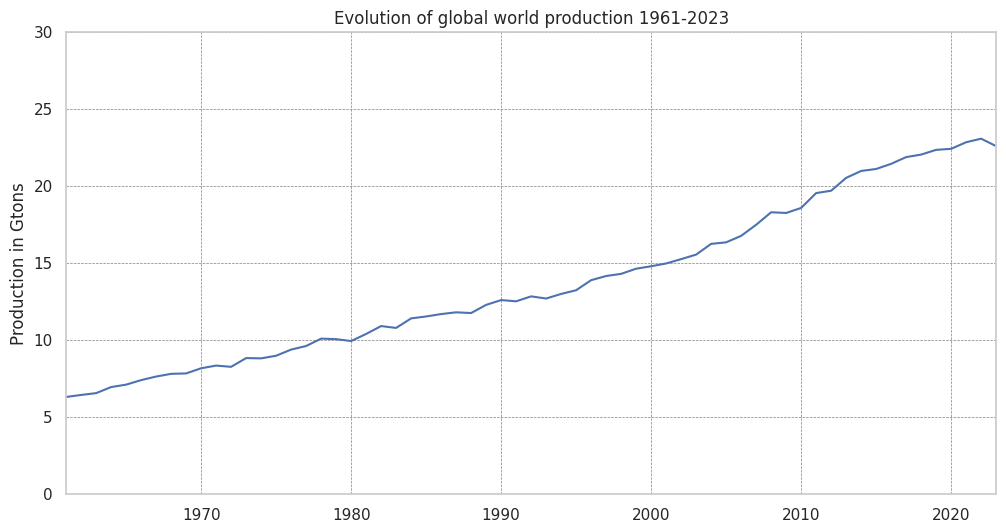

In [20]:
fig = plt.figure(figsize=(12,6))
sns.lineplot(data=prod_global, x="Year", y="Value")
plt.grid(color="grey", lw=0.5, ls="--")
plt.title("Evolution of global world production 1961-2023")
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylim([0,30])
plt.ylabel("Production in Gtons")
plt.show()

**Top producing countries in the world in 1961-2023**

It seems that there are a lot of country groups, we need to get rid of them if we want to focus only on entire countries. Same way we only keep "China" and not "China, mainland". We add this last one to the country_groups definition on top of this notebook

In [21]:
top_producers_values = df_only_prod[~df_only_prod["Area"].isin(country_groups)].groupby("Area")[["Value"]]\
                            .sum()\
                            .sort_values(by="Value", ascending=False)\
                            .nlargest(9, columns="Value")

top_producers_values

,Value
Area,
China,139.287479
India,92.072169
United States of America,86.313502
Brazil,72.511021
USSR,32.894679
Indonesia,21.021856
France,20.128492
Germany,18.666605
Russian Federation,15.315549


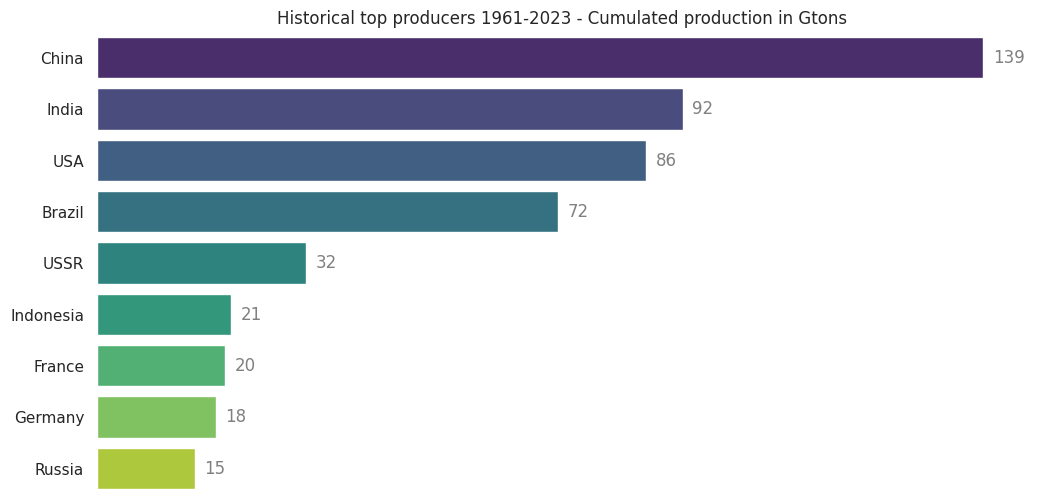

In [22]:
fig = plt.figure(figsize=(12,6))

custom_labels = ["China","India","USA","Brazil","USSR","Indonesia","France","Germany","Russia"]

ax = sns.barplot(x=top_producers_values["Value"], y=top_producers_values.index, palette="viridis")
ax.set_yticks(ax.get_yticks(), labels=custom_labels)
ax.set_xticks([])
plt.title("Historical top producers 1961-2023 - Cumulated production in Gtons")
plt.xlabel(None)
plt.ylabel(None)
plt.grid(False)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.bar_label(ax.containers[0], fmt="%d", color="grey", padding=7) 


plt.show()

Let's include as well countries from USSR that are not Russian Federation (even though it means adding more countries in the study) 

In [23]:
top_producers = top_producers_values.index
top_producers = np.append(top_producers, ["Armenia","Azerbaijan","Belarus","Estonia","Georgia","Kazakhstan","Kyrgyzstan",
          "Latvia","Lithuania","Republic of Moldova","Tajikistan","Turkmenistan","Ukraine","Uzbekistan"])
top_producers

array(['China', 'India', 'United States of America', 'Brazil', 'USSR',
       'Indonesia', 'France', 'Germany', 'Russian Federation', 'Armenia',
       'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Republic of Moldova',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'],
      dtype=object)

In [24]:
yearly_top_production = df_only_prod[df_only_prod["Area"].isin(top_producers)]\
                            .groupby(["Year","Area"])[["Value"]]\
                            .sum()\
                            .reset_index()\
                            .pivot(index="Year", columns="Area", values="Value")\
                            .fillna(0)

Given the production of formers USSR countries, except for Ukraine and Russian Federation, we will group them in "Former USSR countries" 

In [25]:
yearly_top_production["Former USSR countries"] = yearly_top_production[['Uzbekistan', 'Kazakhstan', 'Belarus', 'Azerbaijan',
       'Lithuania', 'Tajikistan', 'Turkmenistan', 'Kyrgyzstan',
       'Republic of Moldova', 'Latvia', 'Armenia', 'Estonia', 'Georgia']].sum(axis=1)
yearly_top_production = yearly_top_production.drop(columns=['Uzbekistan', 'Kazakhstan', 'Belarus', 'Azerbaijan',
       'Lithuania', 'Tajikistan', 'Turkmenistan', 'Kyrgyzstan',
       'Republic of Moldova', 'Latvia', 'Armenia', 'Estonia', 'Georgia'])

In [26]:
# We arrange the columns from the biggest producer in 2023 to the smallest (in top10 list)
yearly_top_production = yearly_top_production[yearly_top_production.loc[2023,:].sort_values(ascending=False).index]

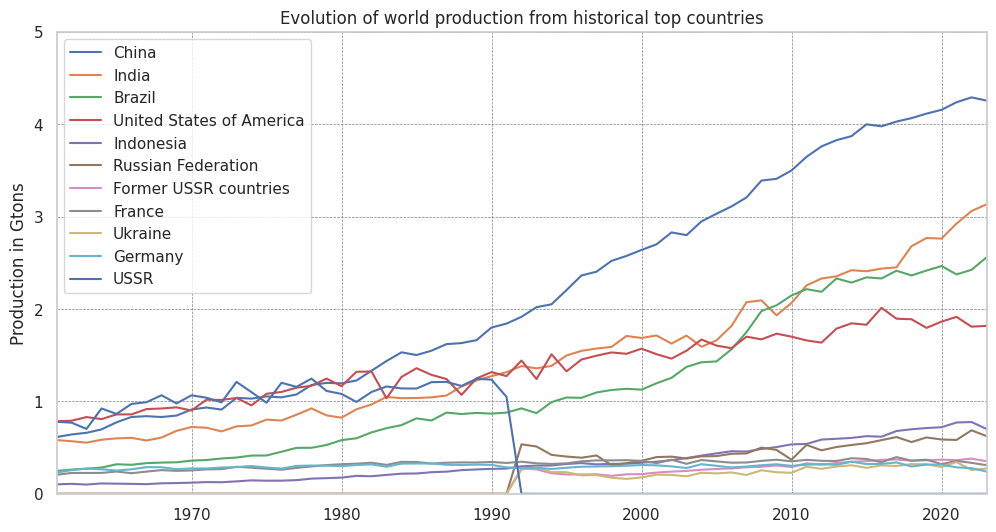

In [27]:
fig = plt.figure(figsize=(12,6))

for country in yearly_top_production.columns: 
    sns.lineplot(data=yearly_top_production, x="Year", y=country, label=country)
    
plt.grid(color="grey", lw=0.5, ls="--")
plt.title("Evolution of world production from historical top countries")
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylim([0,5])
plt.ylabel("Production in Gtons")
plt.show()

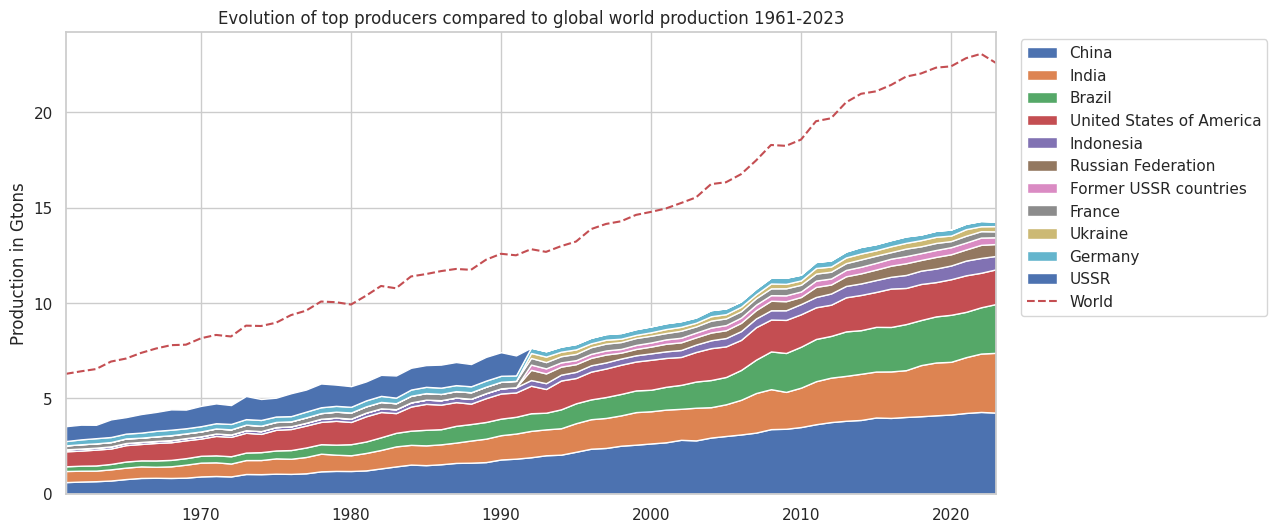

In [28]:
fig = plt.figure(figsize=(12,6))

plt.stackplot(yearly_top_production.index,
             yearly_top_production.T,
             labels=yearly_top_production.columns)

sns.lineplot(data=prod_global, x="Year", y="Value", label="World", color="r", ls="--")

plt.title("Evolution of top producers compared to global world production 1961-2023")
plt.legend(bbox_to_anchor=(1.3,1))
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

We can compute the % of global production coming from the top 10 producers and its evolution overtime

In [29]:
top_production = yearly_top_production.sum(axis=1).reset_index().rename(columns={0:"Value"})

In [30]:
top_production["Percent"] = top_production["Value"] / prod_global["Value"] * 100

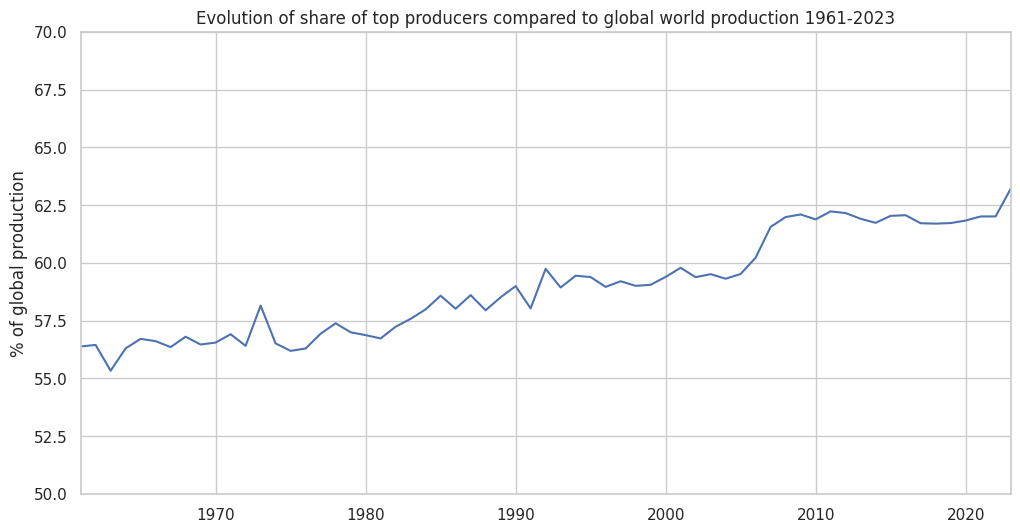

In [31]:
fig = plt.figure(figsize=(12,6))

sns.lineplot(data=top_production, x="Year", y="Percent")

plt.title("Evolution of share of top producers compared to global world production 1961-2023")
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylim(50,70)
plt.ylabel("% of global production")

plt.show()

We can identify that: 
* Between 55 and 63% of the global world production is done by 10 countries (or group of countries) that produce more than any other country (or group of countries) during the given period
* The share of the production is increasing slowly over the years, showing that the global production is more and more dominated by those countries
* A boom is mainly visible during the 2005-2010 period, mainly driven by the major increase in India and Brazil

❓ But are current top producers the same as the historic ones ? Let's have a look and compare top producers in 1961 vs 2023

In [32]:
first_top_production = df_only_prod[(df_only_prod["Year"]==1961) & (~df_only_prod["Area"].isin(country_groups))]\
                            .groupby("Area")[["Value"]]\
                            .sum()\
                            .sort_values(by="Value", ascending=False)\
                            .nlargest(10, columns="Value")

current_top_production = df_only_prod[(df_only_prod["Year"]==2023) & (~df_only_prod["Area"].isin(country_groups))]\
                            .groupby("Area")[["Value"]]\
                            .sum()\
                            .sort_values(by="Value", ascending=False)\
                            .nlargest(10, columns="Value")

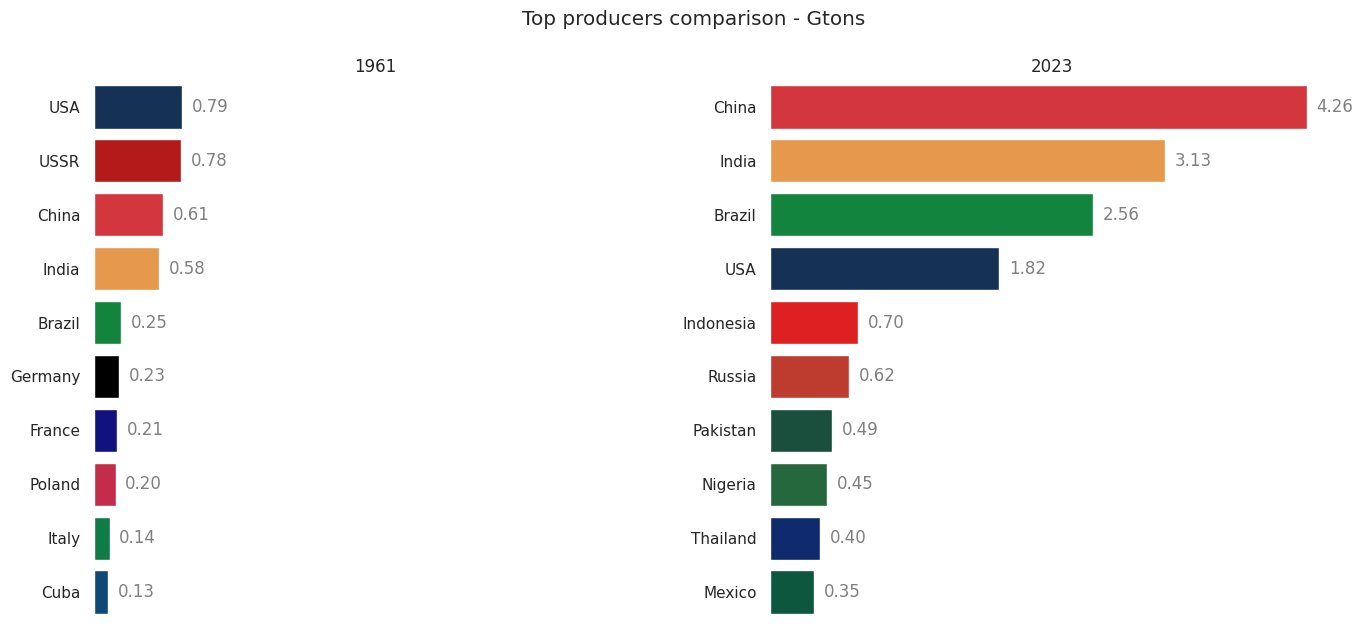

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# 1961
first_labels = ["USA","USSR","China","India","Brazil","Germany","France","Poland","Italy","Cuba"]
first_palette = ["#0A3161","#CD0000","#EE1C25","#FF9933","#009739","#000000","#000091","#DC143C","#008C45","#004B87"]
sns.barplot(x=first_top_production["Value"], y=first_top_production.index, palette=first_palette, ax=ax[0])
ax[0].set_yticks(ax[0].get_yticks(), labels=first_labels)
ax[0].set_xticks([])
ax[0].set_title("1961")
ax[0].set_xlabel(None)
ax[0].set_xlim(0,5)
ax[0].set_ylabel(None)
ax[0].grid(False)
ax[0].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax[0].bar_label(ax[0].containers[0], fmt="%.2f", color="grey", padding=7) 

# 2023
current_labels = ["China","India","Brazil","USA","Indonesia","Russia","Pakistan","Nigeria","Thailand","Mexico"]
current_palette = ["#EE1C25","#FF9933","#009739","#0A3161","#FF0000","#D62718","#115740","#1B7339","#00247D","#006341"]
palette = []
sns.barplot(x=current_top_production["Value"], y=current_top_production.index, palette=current_palette, ax=ax[1])
ax[1].set_yticks(ax[1].get_yticks(), labels=current_labels)
ax[1].set_xticks([])
ax[1].set_title("2023")
ax[1].set_xlabel(None)
ax[0].set_xlim(0,5)
ax[1].set_ylabel(None)
ax[1].grid(False)
ax[1].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax[1].bar_label(ax[1].containers[0], fmt="%.2f", color="grey", padding=7) 

plt.suptitle("Top producers comparison - Gtons")

plt.show()

Conclusions: 
* Biggest producers in 1961 are still top producers in 2023 (USA, China, India, Brazil) 
* China, India and Brazil have taken the lead in yearly global production, with an explosion in Gtons: x10 for Brazil, x7 for China, x5 for India
* New players have been coming: Pakistan, Nigeria, Thailand, Mexico

❓ Which countries have relatively increased the most their production ?

In [34]:
production_evolution=0

In [35]:
# Global production in 1961
production_evolution = df_only_prod[(df_only_prod["Year"]==1961) & (~df_only_prod["Area"].isin(country_groups))]\
                            .groupby("Area")[["Value"]]\
                            .sum()\
                            .sort_values(by="Value", ascending=False)\
                            .rename(columns={"Value":"1961"})

# Global production in 2023
production_evolution["2023"] = df_only_prod[(df_only_prod["Year"]==2023) & (~df_only_prod["Area"].isin(country_groups))]\
                            .groupby("Area")[["Value"]]\
                            .sum()\
                            .sort_values(by="Value", ascending=False)

# Replacing NaN values by 0 and filter null values out, as we are comparing values (case of USSR is deliberately left out)
production_evolution = production_evolution.fillna(0)
production_evolution = production_evolution[(production_evolution["1961"]>0) & (production_evolution["2023"]>0)]

# Production ranks in 1961 and 2023
for col in production_evolution.columns:
    production_evolution[f"{col}_rank"] = production_evolution.rank(ascending=False)[col].astype("int16")
    
# Rank progression from 1961 -> 2023 
production_evolution["Rank_evolution"] = (production_evolution["1961_rank"] - production_evolution["2023_rank"]).astype("int16")
    
production_evolution

,1961,2023,1961_rank,2023_rank,Rank_evolution
Area,,,,,
United States of America,0.785615,1.817637,1,4,-3
China,0.613881,4.255756,2,1,1
India,0.581409,3.132779,3,2,1
Brazil,0.247375,2.558663,4,3,1
Germany,0.228748,0.240863,5,14,-9
...,...,...,...,...,...
Niue,0.000007,0.000014,163,162,1
Tuvalu,0.000006,0.000007,164,165,-1
Faroe Islands,0.000003,0.000020,165,160,5


In [36]:
# Increase GAP between 1961 and 2023
production_evolution["Gap"] = production_evolution["2023"] / production_evolution["1961"]
production_evolution.sort_values(by="Gap", ascending=False)

,1961,2023,1961_rank,2023_rank,Rank_evolution,Gap
Area,,,,,,
United Arab Emirates,0.000069,0.002616,152,118,34,37.850734
Lao People's Democratic Republic,0.001529,0.041478,114,53,61,27.126387
Kuwait,0.000063,0.001532,153,123,30,24.350997
Oman,0.000216,0.004984,145,112,33,23.081555
Qatar,0.000026,0.000518,160,135,25,19.704086
...,...,...,...,...,...,...
Barbados,0.003101,0.000261,100,143,-43,0.084086
Trinidad and Tobago,0.005858,0.000420,79,138,-59,0.071745
Antigua and Barbuda,0.000416,0.000027,130,158,-28,0.064679


In [37]:
production_evolution.sort_values(by="Gap", ascending=False).nlargest(20,"Gap")

,1961,2023,1961_rank,2023_rank,Rank_evolution,Gap
Area,,,,,,
United Arab Emirates,0.000069,0.002616,152,118,34,37.850734
Lao People's Democratic Republic,0.001529,0.041478,114,53,61,27.126387
Kuwait,0.000063,0.001532,153,123,30,24.350997
Oman,0.000216,0.004984,145,112,33,23.081555
Qatar,0.000026,0.000518,160,135,25,19.704086
Malawi,0.003396,0.062495,98,41,57,18.402662
Malaysia,0.008129,0.138008,69,24,45,16.978112
Saudi Arabia,0.001859,0.024625,111,76,35,13.245426
Guatemala,0.006551,0.084913,77,34,43,12.962238


On the biggest evolutions:
* 15 countries have more than x10 their global production, most of which are from middle east: UAE, Kuwait, Oman, Qatar, Saudi Arabia... 
* Other part of the worlds impacted by booming in increase in production : Africa (Malawi, Zambia, Djibouti, Ghana, Mali, Burkina Faso, Côte d'Ivoire, Niger), Southern Americas (Guatemala, Brazil, Paraguay, Bolivia) or South East Asia (Laos, Malaysia, Thailand)
* Speaking only in absolute volumes in 2023, only few countries are in top 30 producers in the world in 2023 : Malaysia (24th), Ghana (30th), Brazil (3rd), Thailand (8th)
* Other booming producing countries are mainly below top 30, marking a booming in small countries

❓ What is the main driver in the "explosion" of production from UAE? 

In [38]:
# Let's focus only on item groups
uae_prod = df_only_prod[(df_only_prod["Area"]=="United Arab Emirates") & (df_only_prod["Item"].isin(item_groups))]\
                            .groupby(["Item","Year"])[["Value"]]\
                            .sum()\
                            .reset_index()\
                            .pivot(index="Year", columns="Item", values="Value")
uae_prod = uae_prod[uae_prod.loc[2023,:].sort_values(ascending=False).index]
uae_prod

Item,Fruit Primary,Vegetables Primary,"Milk, Total","Meat, Total",Sheep and Goat Meat,"Meat, Poultry",Eggs Primary,"Cereals, primary","Beef and Buffalo Meat, primary","Citrus Fruit, Total","Roots and Tubers, Total","Treenuts, Total",Butter and Ghee,"Skim Milk & Buttermilk, Dry"
Year,,,,,,,,,,,,,,
1961,0.000008,0.000001,0.000015,0.000008,0.000001,7.560000e-08,1.350000e-07,0.000000,3.875000e-07,0.000002,0.000000,6.000000e-08,4.980000e-08,NaN
1962,0.000008,0.000001,0.000015,0.000008,0.000001,7.680000e-08,1.360000e-07,0.000000,4.000000e-07,0.000002,0.000000,7.000000e-08,4.980000e-08,NaN
1963,0.000009,0.000001,0.000015,0.000008,0.000001,7.800000e-08,1.370000e-07,0.000000,4.125000e-07,0.000002,0.000000,8.000000e-08,5.395000e-08,NaN
1964,0.000010,0.000001,0.000016,0.000008,0.000001,8.160000e-08,1.380000e-07,0.000000,4.250000e-07,0.000002,0.000000,9.000000e-08,5.395000e-08,NaN
1965,0.000010,0.000001,0.000016,0.000008,0.000001,8.400000e-08,1.400000e-07,0.000000,4.500000e-07,0.000002,0.000000,1.000000e-07,5.810000e-08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,0.000371,0.000287,0.000230,0.000160,0.000062,4.493000e-05,6.170000e-05,0.000026,1.853000e-05,0.000012,0.000004,1.337000e-06,1.549090e-06,NaN
2020,0.000396,0.000323,0.000257,0.000175,0.000064,5.410100e-05,5.367000e-05,0.000026,1.809000e-05,0.000021,0.000001,4.400000e-07,2.145960e-06,NaN
2021,0.000407,0.000328,0.000285,0.000171,0.000063,4.649400e-05,5.999000e-05,0.000023,1.987662e-05,0.000011,0.000002,1.350000e-07,1.970190e-06,NaN


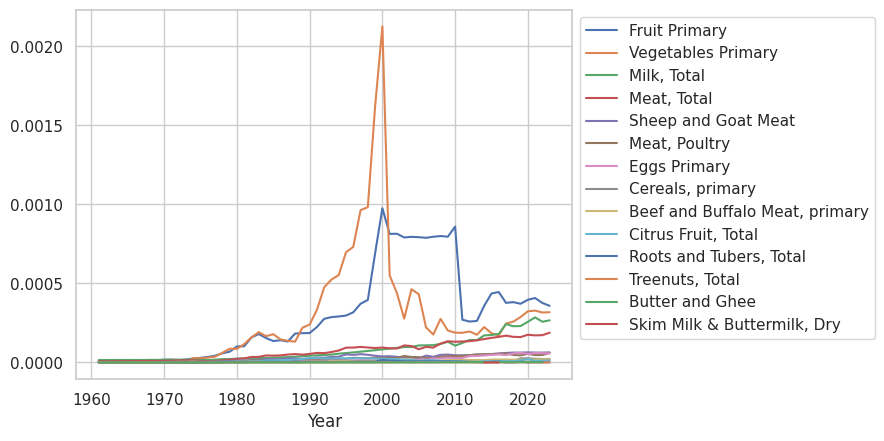

In [39]:
uae_prod.plot()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

❓ Finally, let's have a look on the rank evolution for all countries that has been one day in top10

In [130]:
# Groupping df 
df_rank = (
    df_only_prod[~df_only_prod["Area"].isin(country_groups)]
    .groupby(["Year", "Area"])[["Value"]]
    .sum()
    .reset_index()
)

# Rank for every year
df_rank["Rank"] = df_rank.groupby("Year")["Value"].rank(method="first", ascending=False)

# Top10 countries
top10_countries = df_rank[df_rank["Rank"]<=10]["Area"].unique()

df_rank = df_rank[df_rank["Area"].isin(top10_countries)]

# Pivoting data
global_rank_evolution = df_rank.pivot(index="Area", columns="Year", values="Rank").applymap(lambda row: int(row) if row <= 10 else 15)

In [131]:
global_rank_evolution

Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Area,,,,,,,,,,,,,,,,,,,,,
Argentina,15,15,15,15,15,15,15,15,15,15,...,15,10,10,10,15,9,9,9,10,15
Brazil,5,5,6,5,5,5,5,5,5,5,...,3,3,3,3,3,3,3,3,3,3
China,3,3,3,3,3,3,3,3,3,2,...,1,1,1,1,1,1,1,1,1,1
Cuba,10,15,15,15,15,15,15,15,15,9,...,15,15,15,15,15,15,15,15,15,15
France,7,7,7,7,7,7,7,7,7,7,...,9,9,15,15,15,15,15,15,15,15
Germany,6,6,5,6,6,6,6,6,6,6,...,15,15,15,15,15,15,15,15,15,15
India,4,4,4,4,4,4,4,4,4,4,...,2,2,2,2,2,2,2,2,2,2
Indonesia,15,15,15,15,15,15,15,15,15,15,...,5,5,5,5,5,5,5,5,5,5
Italy,9,9,9,9,9,9,9,9,9,10,...,15,15,15,15,15,15,15,15,15,15


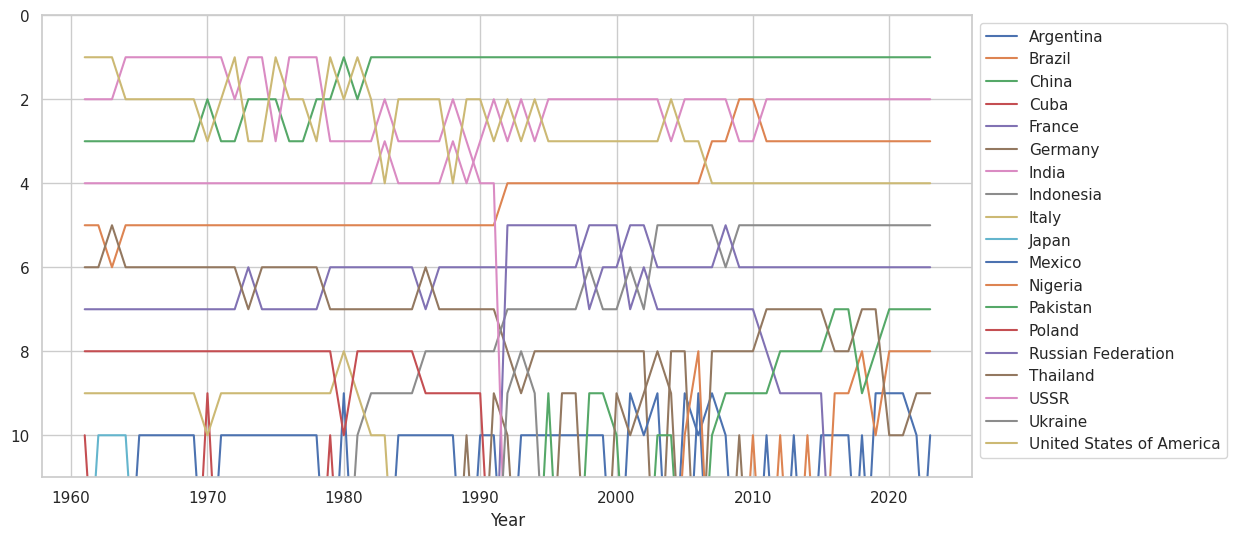

In [137]:
fig = plt.figure(figsize=(12,6))

for idx in range(global_rank_evolution.shape[0]):
    global_rank_evolution.iloc[idx,:].plot(label=global_rank_evolution.index[idx])
    
plt.ylim(11,0)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

**Vegetable, fruit and root production evolution**

In [40]:
world_vegetables = df_prod[(df_prod["Area"]=="World") & (df_prod["Item"]=="Vegetables Primary") & (df_prod["Element"]=="Production")][["Year","Value"]]
world_vegetables["Value"] /= 1e9
world_fruits = df_prod[(df_prod["Area"]=="World") & (df_prod["Item"]=="Fruit Primary") & (df_prod["Element"]=="Production")][["Year","Value"]]
world_fruits["Value"] /= 1e9
world_roots = df_prod[(df_prod["Area"]=="World") & (df_prod["Item"]=="Roots and Tubers, Total") & (df_prod["Element"]=="Production")][["Year","Value"]]
world_roots["Value"] /= 1e9

In [41]:
world_vegetables

,Year,Value
3135840,1961,0.197427
3135841,1962,0.196457
3135842,1963,0.197215
3135843,1964,0.199744
3135844,1965,0.202503
...,...,...
3135898,2019,1.126758
3135899,2020,1.144096
3135900,2021,1.160501
3135901,2022,1.171283


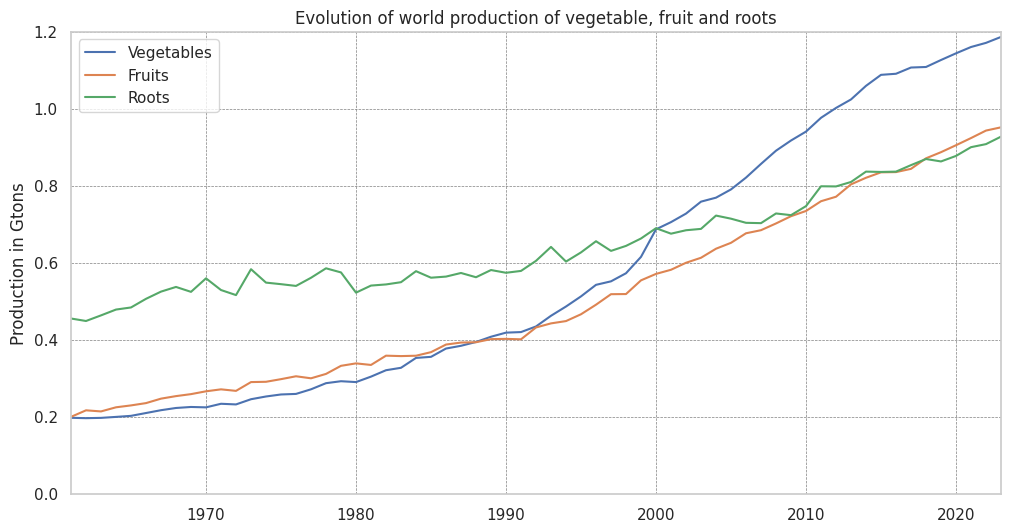

In [42]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
sns.lineplot(data=world_vegetables, x="Year",y="Value",label="Vegetables")
sns.lineplot(data=world_fruits, x="Year",y="Value",label="Fruits")
sns.lineplot(data=world_roots, x="Year",y="Value",label="Roots")
plt.grid(color="grey", lw=0.5, ls="--")
plt.title("Evolution of world production of vegetable, fruit and roots")
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylim([0,1.2])
plt.ylabel("Production in Gtons")
ax.ticklabel_format(style="plain")
plt.show()

**Top producers of eggs**